In [ ]:
# pip install qiskit

In [ ]:
# to do: 
# 
# signed sum using iter_tools package on Python to find the number of combinations for 5 qubits of [+1, -1]: +1+1-1-1-1
# This becomes a classification task where +1 is positive and -1 is negative: this is a signed sum

import numpy as np
from qiskit import QuantumCircuit
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator
from itertools import product

CIRCUIT_DEPTH = 2
QUBITS = 5 
CENTER = int(QUBITS/2)
# gates used is CIRCUIT_DEPTH*2 + 1
# c (central qubit) and l (maximum number of qubits), run 2 loops and iterate to connect to the central qubit

def QSP(circuit, params, theta):
    for i in range(CIRCUIT_DEPTH):
        for q in range(QUBITS):
            circuit.rz(params[i], q)
            circuit.rx(theta, q)
    for q in range(5):       
        circuit.rz(params[CIRCUIT_DEPTH], q)
    return circuit

def entangle(circuit):
    middle = 2
    for i in range(CENTER+1):
        if(i != 0):
            # die
            # continue # skip itself
            circuit.cx(CENTER, CENTER+i) 
            circuit.cx(CENTER, CENTER-i) 

    return circuit


# Function to create a single-qubit variational circuit
def create_circuit(params, theta):
    circuit = QuantumCircuit(QUBITS)
    circuit = QSP(circuit, params, theta)
    circuit = entangle(circuit)
    return circuit


# Function to compute the expectation value <0|U|0> --> |00000>U<00000|
def expectation_value(params, x):
    circuit = create_circuit(params, x)
    state = Statevector.from_instruction(circuit)
    
    # Projector onto the |00000⟩ state
    projector = np.zeros((2**5, 2**5))
    projector[0,0] = 1 # |00000><00000|
    
    # Compute the expectation value
    expectation = state.expectation_value(Operator(projector))
    return np.real(expectation)

# Cost function incorporating alphas and phase parameters
def cost(params, alphas, x_values, y_values):
    error = 0
    for x, y_true, alpha in zip(x_values, y_values, alphas):
        exp_val = expectation_value(params, x)
        y_pred = alpha * exp_val  # Each alpha corresponds to a specific theta (x)
        error += (y_true - y_pred) ** 2
    return error / len(x_values)

Optimal parameters: [0.35985128 2.10110385 1.66023391]
Optimal alphas: [0.70664738 0.68150937 0.60645656 0.54025268 0.50452211 0.50456116
 0.54027316 0.60647405 0.68144884 0.70675949]
Predictions: [0.27012421061399705, 0.3562598000279134, 0.4247814276952444, 0.4724762454911227, 0.49690460888759547, 0.496943071451919, 0.4724941592159269, 0.4247936738097311, 0.35622816019016207, 0.2701670646194285]
Target values: [0.27015115 0.35623731 0.42480378 0.47247847 0.49691675 0.49691675
 0.47247847 0.42480378 0.35623731 0.27015115]


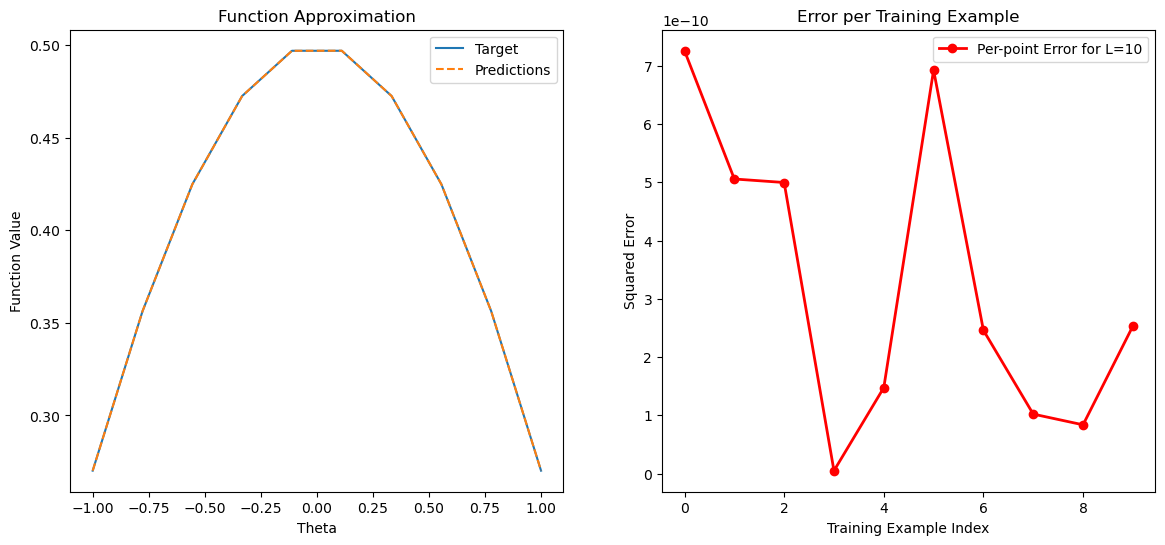

In [32]:
# Task: Function Fitting / Regression
L = 10

# Training data (x, y) for y = mx
# x_train = np.linspace(-1, 1, L)
# m = 2.0
# y_train = m * x_train

# Training data (x, y) for y = mcosx
x_train = np.linspace(-1, 1, L)
m = 0.5
y_train = m * np.cos(x_train)

# Initialize random guesses for parameters, alphas, and phases
param_count = CIRCUIT_DEPTH + 1 
init_params = np.random.uniform(0, 2 * np.pi, param_count)
init_alphas = np.random.uniform(0, 1, len(x_train))

# Training function
def train(params_and_alphas_phases):
    params = params_and_alphas_phases[:param_count]
    alphas = params_and_alphas_phases[param_count:param_count+len(x_train)]
    return cost(params, alphas, x_train, y_train)

# Optimize the parameters, alphas, and phases
init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

# Extract the optimal parameters, alphas, and phases
optimal_params = result.x[:param_count]
optimal_alphas = result.x[param_count:param_count+len(x_train)]

# Test the trained circuit
predictions = [alpha * expectation_value(optimal_params, x) for x, alpha in zip(x_train, optimal_alphas)]


# Print results
print("Optimal parameters:", optimal_params)
print("Optimal alphas:", optimal_alphas)
print("Predictions:", predictions)
print("Target values:", y_train)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x_train, y_train, label="Target")
ax1.plot(x_train, predictions, label="Predictions", linestyle='dashed')
ax1.legend()
ax1.set_title("Function Approximation")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Function Value")

# Calculate prediction errors per point
errors = []
for x, y_true, alpha in zip(x_train, y_train, optimal_alphas):
    y_pred = alpha * expectation_value(optimal_params, x)
    point_error = (y_true - y_pred)**2
    errors.append(point_error)

# Plot errors
ax2.plot(range(len(x_train)), errors, marker='o', linestyle='-', color='red', linewidth=2, label=f"Per-point Error for L={L}")
ax2.set_title("Error per Training Example")
ax2.set_xlabel("Training Example Index")
ax2.set_ylabel("Squared Error")
ax2.legend()

plt.show()


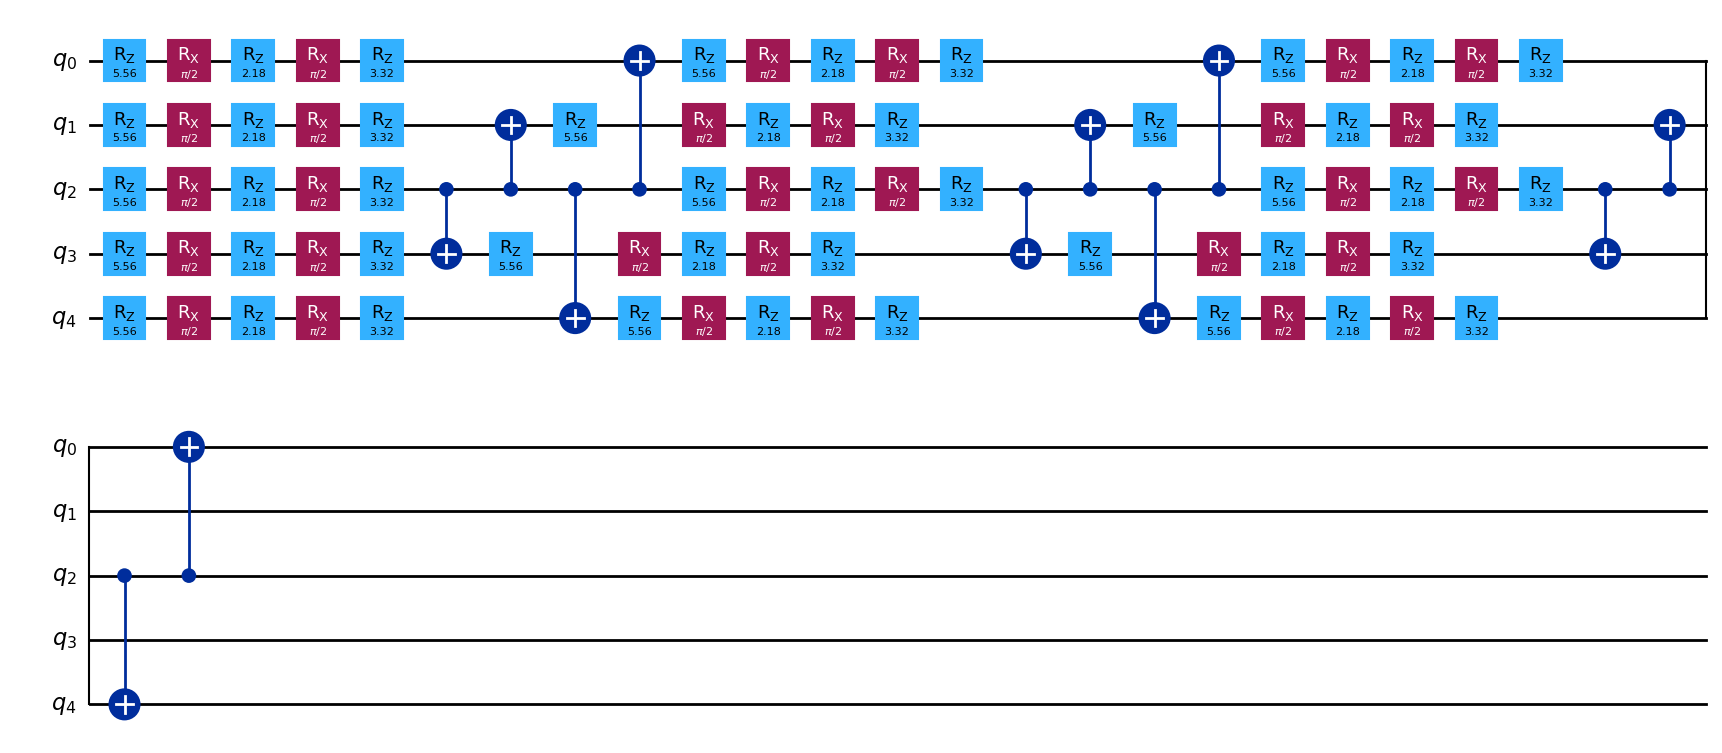

In [ ]:
# Display a test circuit
param_count = CIRCUIT_DEPTH + 1  # RZ per layer + final RZ
testing_params = np.random.uniform(0, 2 * np.pi, param_count)

# c = create_circuit(testing_params,np.pi/2)
c = QuantumCircuit(5)
c = QSP(c, testing_params, np.pi/2)
c = entangle(c)
c = QSP(c, testing_params, np.pi/2)
c = entangle(c)
c = QSP(c, testing_params, np.pi/2)
c = entangle(c)

c.draw(output="mpl")